# Kaggle Monet painting competition

The goal of this project is to create a GAN that can generate monet style images. There have been images provided already, including 300 monet style paintings and 7,028 photos. They've been provided as both JPEGs and tfrec. I'm going to try my best to create this model.

## Import statements

In [1]:
from IPython.display import display
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import matplotlib.patches as patches


from tifffile import imread
from kaggle_datasets import KaggleDatasets

import zipfile
from io import BytesIO

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from functools import partial

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryCrossentropy
from kaggle_datasets import KaggleDatasets

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Loading the images

Let us load the images and see what they look like.

In [4]:
monet_path = "../input/gan-getting-started/monet_jpg/"
photo_path = "../input/gan-getting-started/photo_jpg/"

In [5]:
def image_path(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image_names.append(filename)
    return image_names

In [6]:
monet_filenames = image_path(monet_path)
photo_filenames = image_path(photo_path)
print(len(monet_filenames), "monet paintings")
print(len(photo_filenames), "photos")

300 monet paintings
7038 photos


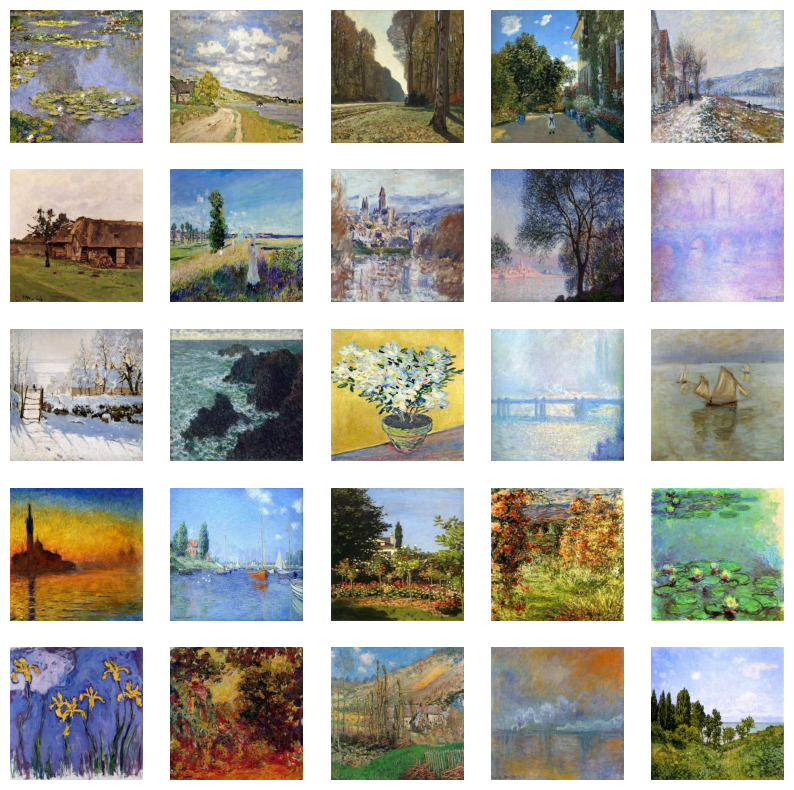

In [7]:
plt.figure(figsize=(10, 10))
for i in range(5 * 5):
    image = plt.imread(monet_path + monet_filenames[i])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

Admittedly, I didn't know what monet style paintings are. I've seen paintings resembling these, but didn't know what the term for them was. Let us now see what the photos look like.

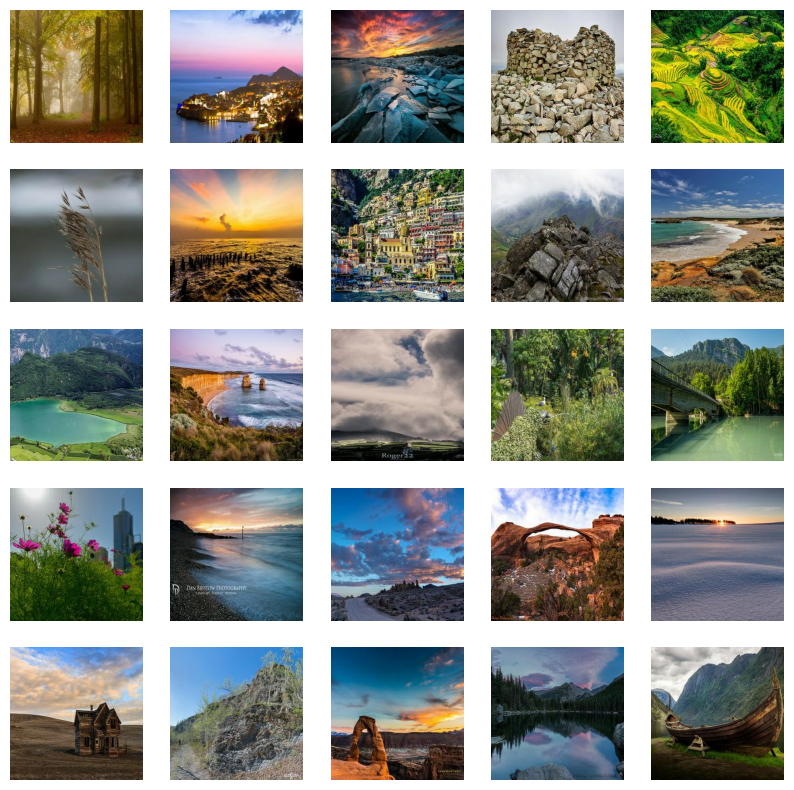

In [8]:
plt.figure(figsize=(10, 10))
for i in range(5 * 5):
    image = plt.imread(photo_path + photo_filenames[i])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

Well, they do look like photos. A couple of the ones displayed here also have a watermark on them.

## Processing images for training

Here I create a dataset with the filenames, and add labels to specify whether it is a painting. A label of 1 means that it is and a label of 0 is given for photos.

In [9]:
monet_dataset = pd.DataFrame(monet_filenames, columns =['filename'])
monet_dataset["filename"] = "monet_jpg/" + monet_dataset["filename"]
monet_dataset["label"] = "1"
monet_dataset.head()

,filename,label
0,monet_jpg/f4413e97bd.jpg,1
1,monet_jpg/7341d96c1d.jpg,1
2,monet_jpg/de6f71b00f.jpg,1
3,monet_jpg/99d94af5dd.jpg,1
4,monet_jpg/99a51d3e25.jpg,1


In [10]:
photo_dataset = pd.DataFrame(photo_filenames, columns =['filename'])
photo_dataset["filename"] = "photo_jpg/" + photo_dataset["filename"]
photo_dataset["label"] = "0"
photo_dataset.head()

,filename,label
0,photo_jpg/fb97febc5f.jpg,0
1,photo_jpg/c54c5368af.jpg,0
2,photo_jpg/4a06596662.jpg,0
3,photo_jpg/2629524a69.jpg,0
4,photo_jpg/5e64b64de8.jpg,0


In [11]:
full_dataset = pd.concat([monet_dataset, photo_dataset], axis=0)
full_dataset.head()

,filename,label
0,monet_jpg/f4413e97bd.jpg,1
1,monet_jpg/7341d96c1d.jpg,1
2,monet_jpg/de6f71b00f.jpg,1
3,monet_jpg/99d94af5dd.jpg,1
4,monet_jpg/99a51d3e25.jpg,1


In [12]:
datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,  # using 20% of training data for validation
                                  )

In [13]:
train_generator = datagen.flow_from_dataframe(
    dataframe=full_dataset,
    directory="../input/gan-getting-started/",
    x_col="filename",
    y_col="label",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=full_dataset,
    directory="../input/gan-getting-started/",
    x_col="filename",
    y_col="label",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 5871 non-validated image filenames belonging to 2 classes.
Found 1467 non-validated image filenames belonging to 2 classes.


## Model Creation

It's time to actually start creating the GAN

### Creating the discriminator

This is my discriminator model for the GAN. It looks pretty simple. It just downscales the image usinga  convolutional neural network and then classifies it.

In [14]:
def Discriminator():
    discriminator = keras.Sequential(
        [
            keras.Input(shape=[256, 256, 3]),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    return discriminator

In [15]:
discriminator = Discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       524416    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)          

### Pre-training the discriminator

I thought it would be a good idea to train the discriminator using the paintings and photos first before we even implement the GAN. We can continue to train it using the GAN too later.

In [16]:
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                      loss='binary_crossentropy',
                      metrics=['accuracy',AUC(name="auc")])
fitted = discriminator.fit(train_generator, validation_data=validation_generator, epochs=2)

Epoch 1/2
46/46 [==============================] - 64s 1s/step - loss: 0.0474 - accuracy: 0.9954 - auc: 0.0000e+00 - val_loss: 12.8637 - val_accuracy: 0.7955 - val_auc: 0.5000
Epoch 2/2
46/46 [==============================] - 26s 551ms/step - loss: 4.1938e-05 - accuracy: 1.0000 - auc: 0.0000e+00 - val_loss: 13.4829 - val_accuracy: 0.7955 - val_auc: 0.5000


Since the training accuracy has a perfect score and the validation accuracy doesn't seem to have improved, it doesn't make much sense to train the model further. We can continue training it using the GAN.

### Loading tfrec

When working with a GAN, it makes more sense to use a TFREC rather than a JPEG. Let's read it now.

In [18]:
GCS_PATH = KaggleDatasets().get_gcs_path()
monet_tfrec_filenames = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_tfrec_filenames = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [19]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.string)
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=tf.data.AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.batch(4)
    return dataset

In [20]:
monet_tfrec = get_dataset(monet_tfrec_filenames, labeled=False)
photo_tfrec = get_dataset(photo_tfrec_filenames, labeled=False)

### Creating the Generator

The generator here just takes an image, downscales it, and the upscales it back to generate a new image. This is useful when you want to convert the photo into a monet style painting, which is what we'll be doing.

In [21]:
def Generator():
    generator = keras.Sequential(
        [
            keras.Input(shape=[256, 256, 3]),
            layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(),
            #layers.Dense(64*64*256, use_bias=False),
            #layers.Reshape((64, 64, 256)),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ],
        name="generator",
    )
    return generator

In [29]:
generator = Generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128, 128, 256)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       524416    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 128)      409600    
 ranspose)                                                       
                                                         

### Creating the GAN

Now it's time to finally create the GAN. It's an object of the type `keras.Model` takes the generator and discriminator in the constructor and trains them every step. It essentially creates a fake image using the generator by passing a photo as an input. It then calculates the discriminator loss using this fake image and a real monet painting, and uses this discriminator loss to train both the discriminator and generator.

Feel free to go through the code yourself to understand what it's doing.

In [23]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_optimizer, disc_optimizer, disc_loss_fn, gen_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.disc_loss_fn = disc_loss_fn
        self.gen_loss_fn = gen_loss_fn

    def train_step(self, real_batch):
        (real_monet, real_photo) = real_batch
        #gen_monet = tf.random.uniform(shape=(1, 100), minval=-1., maxval=1.)
        
        # train disc
        with tf.GradientTape() as tape:
            # random noise to fake monet 
            fake_image = self.generator(real_photo, training=True)
            
            # disc the fake and real image
            d_fake_logits = self.discriminator(fake_image, training=True)
            d_real_logits = self.discriminator(real_monet, training=True)
            
            # get discriminator loss
            disc_loss = self.disc_loss_fn(d_real_logits, d_fake_logits)
            
        grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        self.disc_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        
        # Train generator
        with tf.GradientTape() as tape:
            # get generator loss
            fake_image = self.generator(real_photo, training=True)
            d_fake_logits = self.discriminator(fake_image, training=True)
            gen_loss = self.gen_loss_fn(d_fake_logits)
             
        grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        return {
            "disc_loss": disc_loss,
            "gen_loss": gen_loss
        }

### Loss Functions

In [24]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [25]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

### Training the GAN

This is the part where we finally train the GAN by passing both the monet style paintings and the photos as input.

In [30]:
epochs = 5

gan = GAN(generator, discriminator)
gan.compile(
    disc_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    gen_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    disc_loss_fn=discriminator_loss,
    gen_loss_fn=generator_loss,
)

gan.fit(
    tf.data.Dataset.zip((monet_tfrec, photo_tfrec)), epochs=epochs
)

Epoch 1/5
75/75 [==============================] - 18s 85ms/step - disc_loss: 476.9359 - gen_loss: 0.6321
Epoch 2/5
75/75 [==============================] - 14s 83ms/step - disc_loss: 0.3858 - gen_loss: 0.7023
Epoch 3/5
75/75 [==============================] - 14s 84ms/step - disc_loss: 0.1854 - gen_loss: 1.3219
Epoch 4/5
75/75 [==============================] - 14s 82ms/step - disc_loss: 0.2656 - gen_loss: 1.5046
Epoch 5/5
75/75 [==============================] - 15s 83ms/step - disc_loss: 0.0607 - gen_loss: 2.9160


## Results and Analysis

Now let us look at how good of a job our model did. We can sample 5 photos and compare them to the monet style paintings generated by passing them as input.

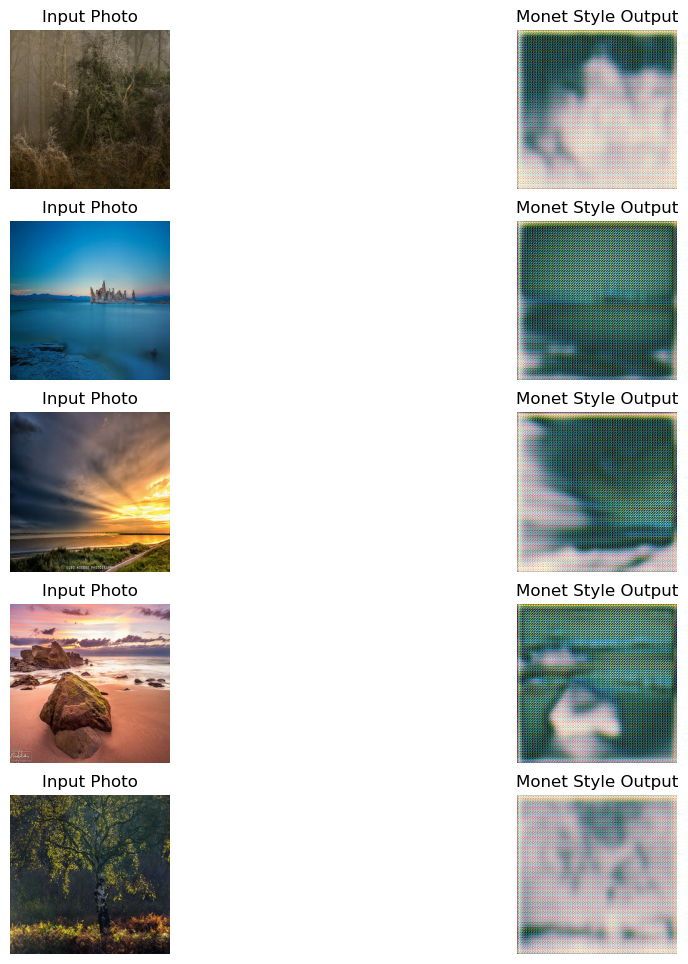

In [44]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_tfrec.take(5)):
    prediction = generator(img, training=False)[0].numpy()
    #prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img[0]/255)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Style Output")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

You can see that the images on the right vaguely resemble monet style paintings, but not exactly. One thing you can notice is that it has both horizontal and vertical scan lines, which shouldn't be present in monet style paintings.

You can also notice that the image seems to be a combination of two colors, but this isn't too much of an issue since there are monet style paintings in the original dataset that don't have many colors. Here are 3 of them below.

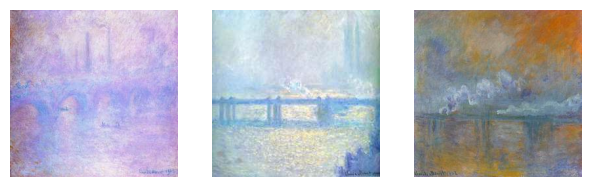

In [10]:
plt.figure(figsize=(10, 10))
inds = [9,13,23]
i=1
for ind in inds:
    image = plt.imread(monet_path + monet_filenames[ind])
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.axis("off")
    i=i+1

### Hyperparameter Tuning and New Models

I did perform some hyperparameter tuning on the model and also tried other models. Unfortunately, I can't show it here because I ran out of the GPU quota of my Kaggle notebook. I decided to instead list down what I found. Here's everything I tried, and the results.

1. **Increasing the number of epochs**: When I tried to do this, it would converge into a single color instead of a combination of two colors. Since this is not what I wanted, training it at 5 epochs seemed better.
2. **Changing the learning rates**: Increasing the learning rate for either the discriminator or the generator even by a little would have the same consequence as increasing the number of epochs. It would converge into a single color, which is not what I wanted.
3. **Using random numbers as input for the generator instead of photos**: When I did this, I did get different results on every attempt. No matter what I tried though, it wouldn't look like a painting. It instead resembled a microscopic image of amoeba.
4. **Implementing a CycleGAN**: I attempted this after seeing a few other Kaggle users do it. When I did though, my Kaggle notebook would run out of memory every time.

## Conclusion

I would say that I am moderately satisfied with my model. While the result doesn't look like a monet style painting, it was getting close. I will try to implement a Cyclic GAN again in the future and hopefully it does a better job.

For now, I am submitting my current results to the competition.

In [35]:
def generate_and_save(generator, ds):
    count = 0
    if os.path.exists('images.zip'):
        os.remove('images.zip')
    with zipfile.ZipFile('images.zip', 'w') as zipf:
        for images_batch in ds:
            predictions = generator(images_batch, training=False)
            for pred in predictions:
                count += 1
                generated_image = keras.utils.array_to_img(pred)
                generated_image_bytes = BytesIO()
                generated_image.save(generated_image_bytes, format='JPEG')
                generated_image_bytes.seek(0)
                zipf.writestr(f'generated_image_{count}.jpg', generated_image_bytes.getvalue())
                if count % 1024 == 0:
                    print(f'Archived images: {count}')

In [36]:
generate_and_save(generator, photo_tfrec)

Archived images: 1024
Archived images: 2048
Archived images: 3072
Archived images: 4096
Archived images: 5120
Archived images: 6144
